# Вебинар 5. Обучение без учителя.

**План занятия**
* [Введение](#intro)
* [Понижение размерности](#reduce)
    * [PCA -  Principal Component Analysis](#pca)
    * [TSNE](#tsne)
* [Кластеризация](#cluster)
    * [K-means](#kmeans)
    * [DBSCAN](#dbscan)
    * [Иерархическая](#aggl)
* [Наглядный пример](#example)
* [Задание для курсового проекта](#course)

## Введение <a class='anchor' id='intro'>

Интересные техники применения кластеризации - кластеризация временных рядов (дополнительно)
https://www.youtube.com/watch?v=ShbWTtOyobE

1. Кластеризация - разделение данных на группы<br>
Сегментирование данных
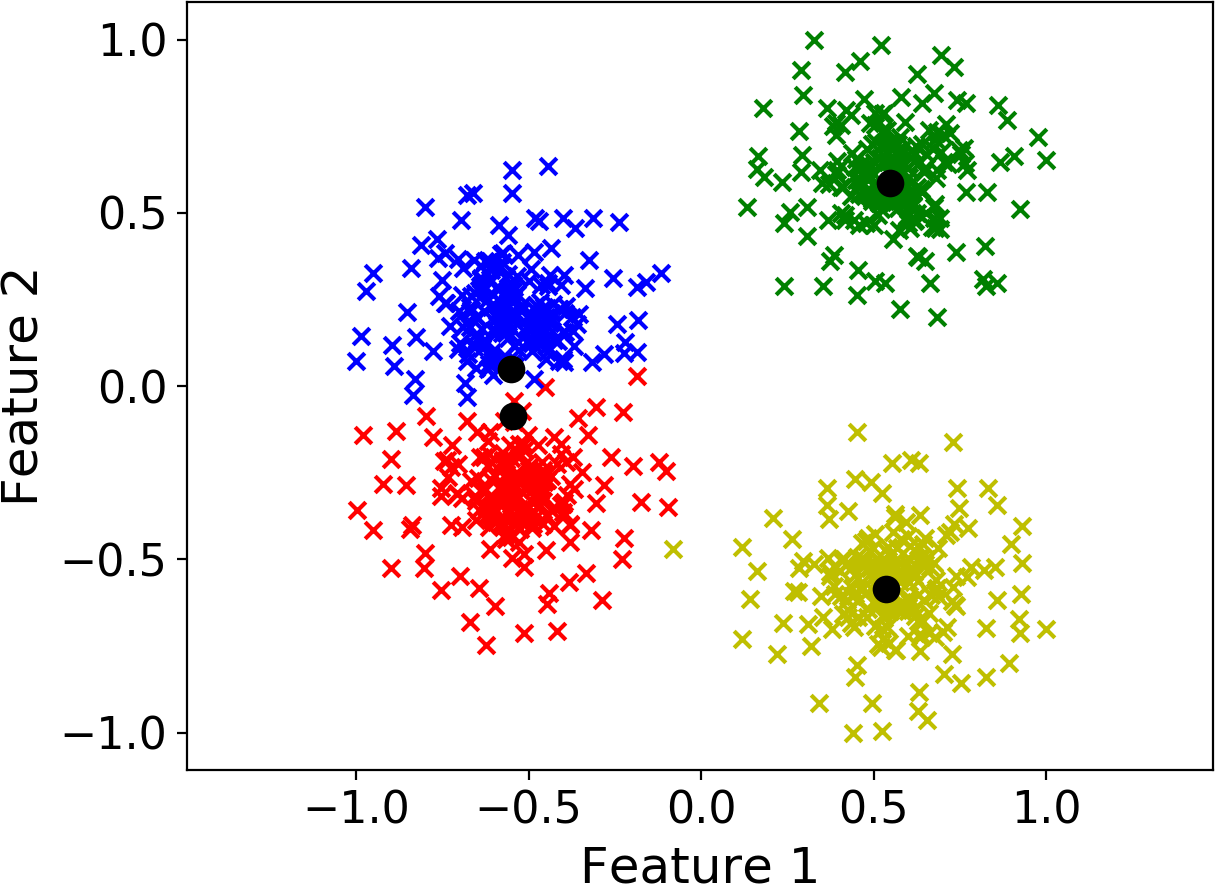
2. Понижение размерности - из N фичей сделать 2 или 3, и визуализировать<br>
**Для чего может быть полезно понижение размерности:**

*1. Визуализация*

Тяжело визуализировать многомерное пространство
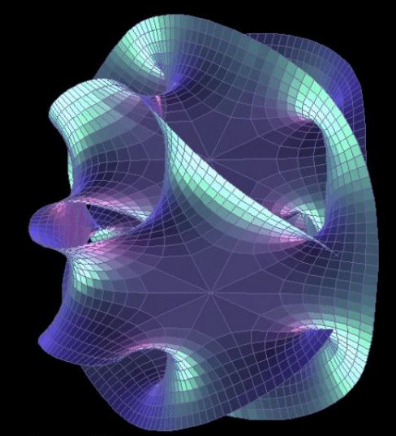
*2. Сжатие с сохранением смысла*

Все признаки важные, отбрасывать их нельзя, но можно их сжать
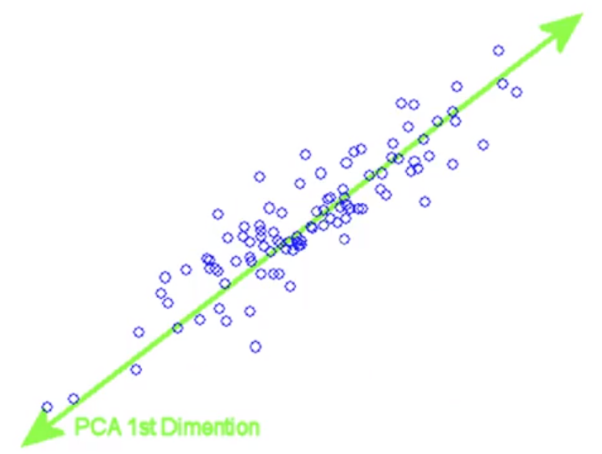
*3. Абстрактные признаки*

Получить новые признаки на основе старых
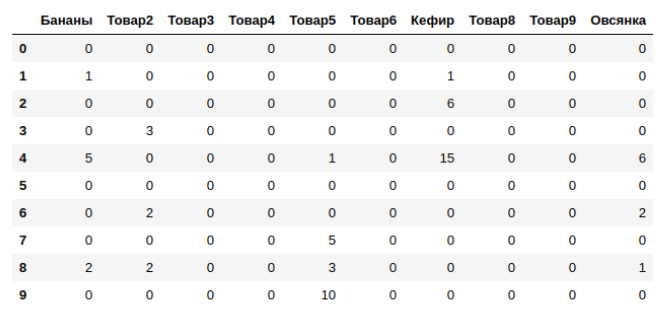

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
matplotlib.rcParams.update({'font.size': 12})

In [4]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

https://habr.com/ru/post/304214/

In [31]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [5]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

https://habr.com/ru/company/jetinfosystems/blog/467745/

In [6]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [7]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/GB/Python_libs/9. Вебинар 4 Unsupervised learning/housing_prepared.csv'
TRAIN_DATASET_EXT_PATH = '/content/drive/My Drive/GB/Python_libs/9. Вебинар 4 Unsupervised learning/housing_train_ext.csv'

### Загрузка данных

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [9]:
df = pd.read_csv(TRAIN_DATASET_PATH, ';')
df.head()

longitude  latitude  ...  NEAR OCEAN  median_house_value
0    -122.23     37.88  ...           0            452600.0
1    -122.22     37.86  ...           0            358500.0
2    -122.24     37.85  ...           0            352100.0
3    -122.25     37.85  ...           0            341300.0
4    -122.25     37.85  ...           0            342200.0

[5 rows x 13 columns]

In [10]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
<1H OCEAN               int64
INLAND                  int64
NEAR BAY                int64
NEAR OCEAN              int64
median_house_value    float64
dtype: object

### Определение признакового пространства

In [11]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value'].values

X.head(2)

longitude  latitude  housing_median_age  ...  INLAND  NEAR BAY  NEAR OCEAN
0    -122.23     37.88                41.0  ...       0         1           0
1    -122.22     37.86                21.0  ...       0         1           0

[2 rows x 12 columns]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## Масштабирование / Нормализация

$$dist(x, y) = \sqrt(\sum(x_i - y_i)^2)$$ 

Диапазон по умолчанию для функции, возвращаемой MinMaxScaler, составляет от 0 до 1.

Идея StandardScaler заключается в том, что он преобразует ваши данные таким образом, что его распределение будет иметь среднее значение 0 и стандартное отклонение 1. Учитывая распределение данных, каждое значение в наборе данных будет вычтено из среднего значения выборки, а затем разделено по стандартному отклонению всего набора данных. 
Около 68% значений будут находиться в диапазоне от -1 до 1.

Обратите внимание, что диапазон для каждой функции после применения RobustScaler больше, чем для MinMaxScaler.

Используйте RobustScaler, если вы хотите уменьшить влияние выбросов по сравнению с MinMaxScaler.

https://www.machinelearningmastery.ru/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02/

In [13]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min)
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = StandardScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

longitude  latitude  housing_median_age  ...    INLAND  NEAR BAY  NEAR OCEAN
0   0.891912 -0.215156           -1.984022  ...  1.414938 -0.348829   -0.374977
1   0.951704 -0.767723           -1.009749  ...  1.414938 -0.348829   -0.374977

[2 rows x 12 columns]

In [14]:
X.head(2)

longitude  latitude  housing_median_age  ...  INLAND  NEAR BAY  NEAR OCEAN
0    -122.23     37.88                41.0  ...       0         1           0
1    -122.22     37.86                21.0  ...       0         1           0

[2 rows x 12 columns]

В _scaled все признаки измеряются в одних единицах

In [15]:
X_train_scaled.describe()

longitude      latitude  ...      NEAR BAY    NEAR OCEAN
count  1.318200e+04  1.318200e+04  ...  1.318200e+04  1.318200e+04
mean  -1.385286e-15 -7.174675e-16  ...  3.155427e-15  5.556168e-16
std    1.000038e+00  1.000038e+00  ...  1.000038e+00  1.000038e+00
min   -2.376715e+00 -1.454950e+00  ... -3.488286e-01 -3.749766e-01
25%   -1.096170e+00 -8.048707e-01  ... -3.488286e-01 -3.749766e-01
50%    5.182124e-01 -6.469944e-01  ... -3.488286e-01 -3.749766e-01
75%    7.872763e-01  9.549862e-01  ... -3.488286e-01 -3.749766e-01
max    2.625879e+00  2.914510e+00  ...  2.866737e+00  2.666833e+00

[8 rows x 12 columns]

Когда **необходимо** применять масштабирование/нормализацию:
- Во всех методах понижения размерности
- **В линейной регрессии**
- В KNN

Когда **не обязательно** использовать масштабирование/нормализацию:
- Дерево решений
- Случайный лес
- Градентный бустинг

## Понижение размерности <a class='anchor' id='reduce'>

### PCA -  Principal Component Analysis (метод главных компонент) <a class='anchor' id='pca'>

**Из 2-мерного пространства в 1-мерное**

фичи X1, X2

$$component_1 = a_1*X_1 + a_2*X_2$$

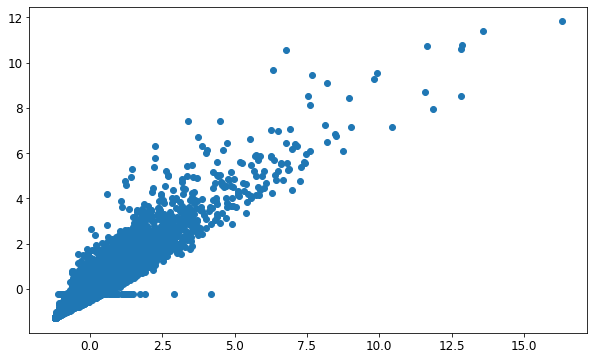

In [16]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.show()

In [17]:
X_small.head()

total_rooms  total_bedrooms  component_1
0    -1.208368       -1.286537    -1.764164
1     0.196054       -0.035796     0.113319
2     0.534686        0.591971     0.796666
3     0.139230       -0.074133     0.046031
4     1.469735        0.915439     1.686572

PCA подбирает такую линию, вдоль которой лежат точки

В линейной регресии вы минимизируете "вертикальную разницу":
    $$(y - y_{pred})^2$$
    
В PCA вы минимизируете среднее расстояние от точек до линии - перпендикуляр к линии:
$$ \sqrt(x1_{i} - x1'_{i})^2 + (x2_{i} - x2'_{i})^2$$

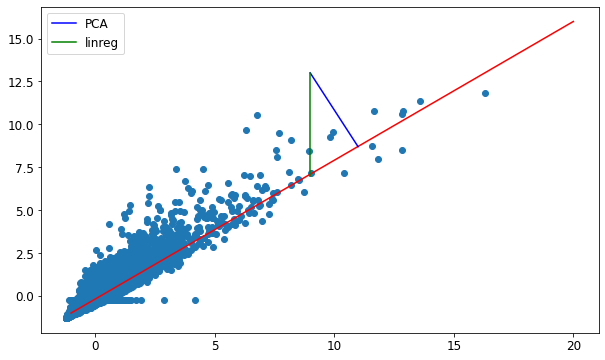

In [18]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.plot([-1, 20], [-1, 16], c='r')
plt.plot([9, 11], [13, 8.7], c='b', label='PCA')
plt.plot([9, 9], [13, 7], c='g', label='linreg')
plt.legend()
plt.show()

**Как работает PCA из 3d в 2d**

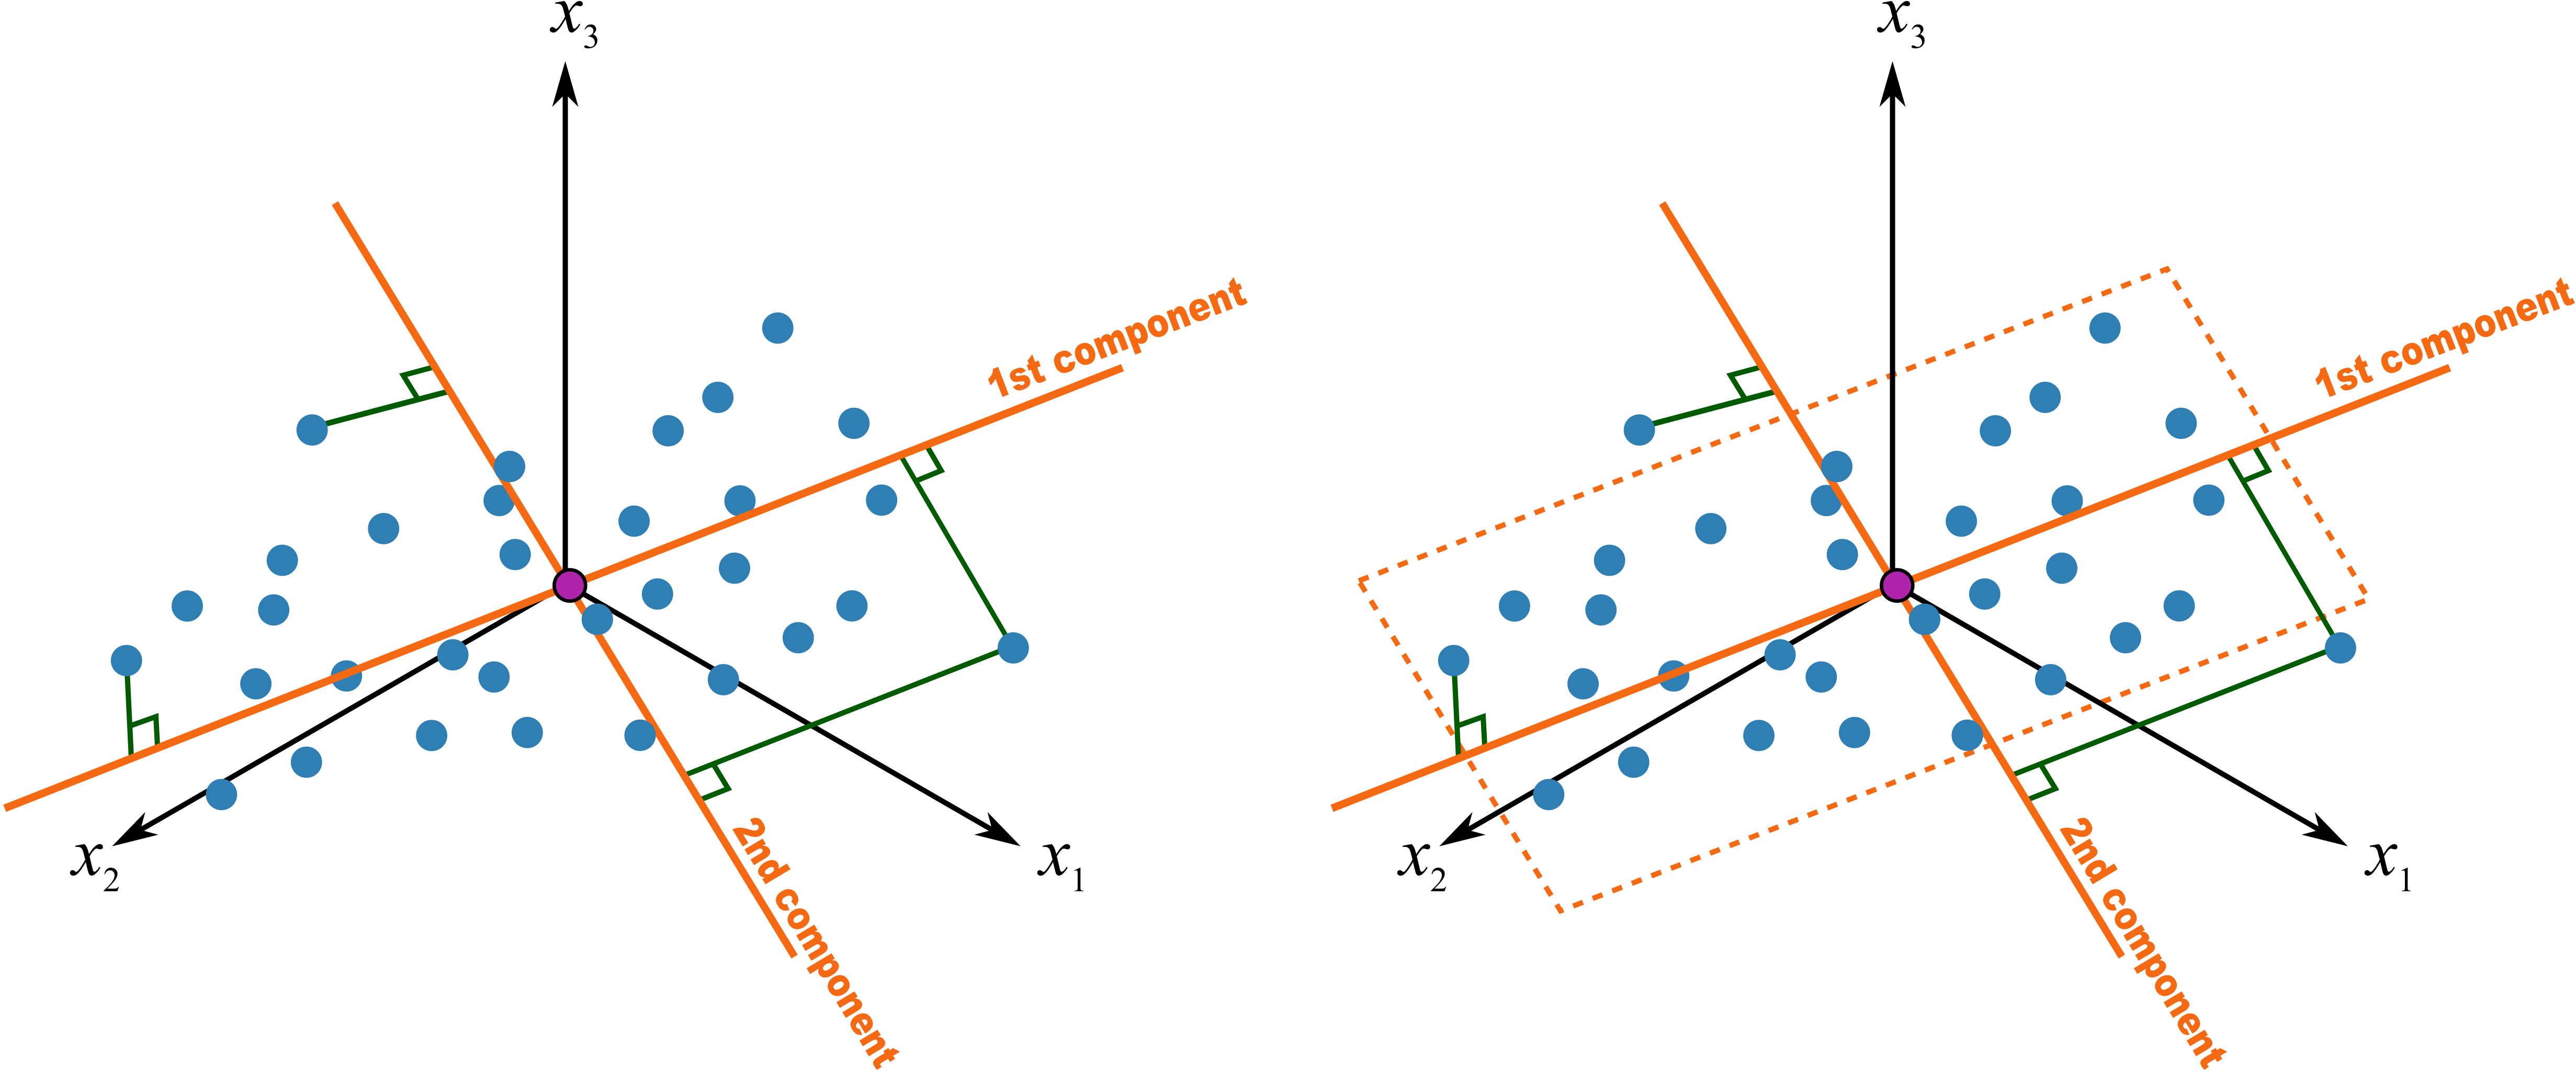

**Снижение размерности до 2х компонент**

In [19]:
import inspect
print(inspect.getsource(reduce_dims))

def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 



In [21]:
len(X_train_scaled.columns)

12

In [22]:
reduce_dims(X_train_scaled, dims=2, method='pca')

(PCA(n_components=2, random_state=42),        component_1  component_2
 0        -2.007173    -0.167309
 1         0.486355    -0.195870
 2         1.016635    -1.422552
 3         0.109867     0.768449
 4         2.773809    -1.842003
 ...            ...          ...
 13177    -2.098998     2.089477
 13178    -2.432051     1.609556
 13179    -0.146646    -0.896177
 13180    -0.935068     0.125816
 13181    -2.780257     1.345177
 
 [13182 rows x 2 columns])

In [23]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

component_1  component_2
0    -2.007173    -0.167309
1     0.486355    -0.195870

In [24]:
X_train_scaled.shape, components_2d.shape

((13182, 12), (13182, 2))

In [25]:
X_train_scaled.head()

longitude  latitude  housing_median_age  ...    INLAND  NEAR BAY  NEAR OCEAN
0   0.891912 -0.215156           -1.984022  ...  1.414938 -0.348829   -0.374977
1   0.951704 -0.767723           -1.009749  ...  1.414938 -0.348829   -0.374977
2   0.727484 -0.753793            0.289281  ... -0.706745 -0.348829   -0.374977
3  -1.569523  1.284669           -0.684992  ... -0.706745 -0.348829   -0.374977
4   1.355300 -1.301717           -0.928560  ... -0.706745 -0.348829   -0.374977

[5 rows x 12 columns]

In [26]:
dim_reducer2d

PCA(n_components=2, random_state=42)

In [30]:
dims = 2
components = dim_reducer2d.transform(X_test_scaled)
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_2d_test = pd.DataFrame(data = components, columns = colnames)
components_2d_test.head()

component_1  component_2
0     0.726187    -2.038833
1     0.208958    -2.203105
2    -1.431044    -0.576895
3    -1.233543     1.559051
4    -0.394432     2.032628

In [32]:
print(inspect.getsource(display_components_in_2D_space))

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()



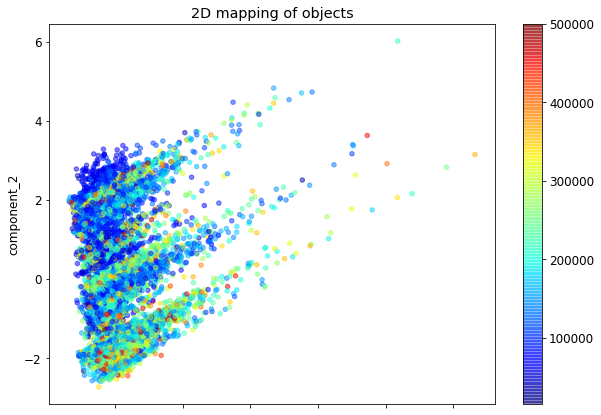

In [33]:
display_components_in_2D_space(components_2d, y_train)

**Снижение размерности до 3х компонент**

In [34]:
dim_reducer3d, components_3d = reduce_dims(X_train_scaled, dims=3, method='pca')

In [35]:
dims = 3
components = dim_reducer3d.transform(X_test_scaled)
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_3d_test = pd.DataFrame(data = components, columns = colnames)
components_3d_test.head()

component_1  component_2  component_3
0     0.726187    -2.038833    -0.224166
1     0.208958    -2.203105    -0.134591
2    -1.431044    -0.576895    -1.145173
3    -1.233543     1.559051     1.149648
4    -0.394432     2.032628    -1.186800

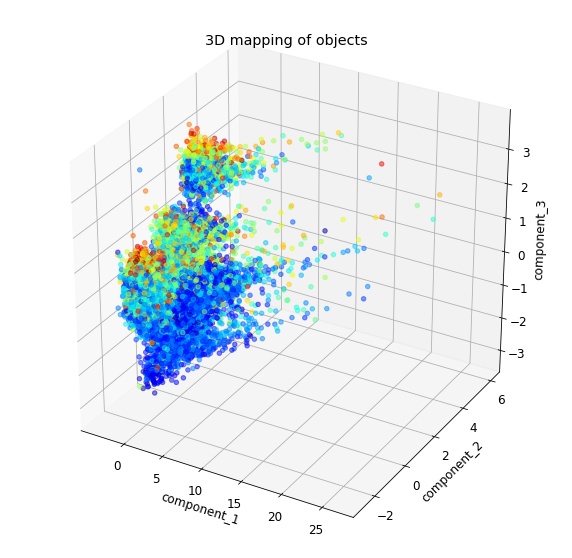

In [36]:
display_components_in_3D_space(components_3d, y_train)

## TSNE <a class='anchor' id='tsne'>

Объяснение можно посмотреть [здесь](https://habr.com/ru/post/267041/)

https://distill.pub/2016/misread-tsne/

Принцип работы метода t-SNE заключается в том, что он пытается сохранять расстояния между каждым входящим вектором.

Шаг 1: В многомерном пространстве создается вероятностное распределение, которое обусловлено расстоянием между точками (преобразование многомерной дистанции между точками в условные вероятности, отражающие сходство точек)

Шаг 2: Алгоритм пытается воссоздать меньше размерное пространство, в котором наилучшим образом сохраняется вероятностное распределение

In [37]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=1)
components_2d_tsne.head(2)

CPU times: user 3min 5s, sys: 515 ms, total: 3min 5s
Wall time: 1min 55s


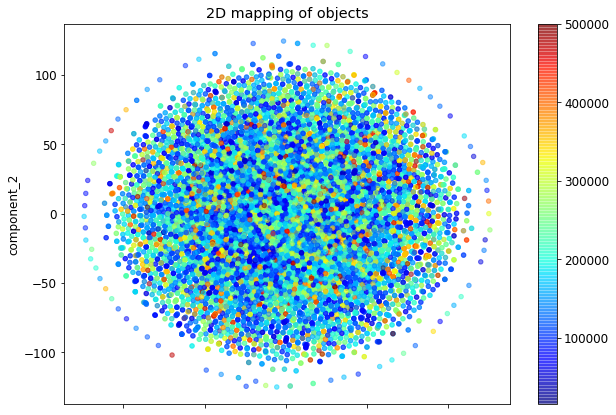

In [38]:
display_components_in_2D_space(components_2d_tsne, y_train)

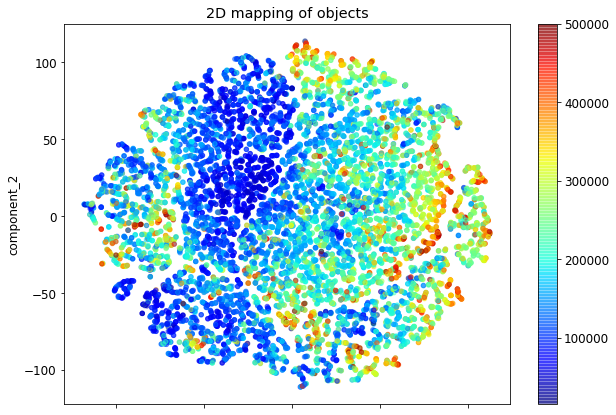

CPU times: user 2min 49s, sys: 498 ms, total: 2min 49s
Wall time: 1min 32s


In [39]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=5)
display_components_in_2D_space(components_2d_tsne, y_train)

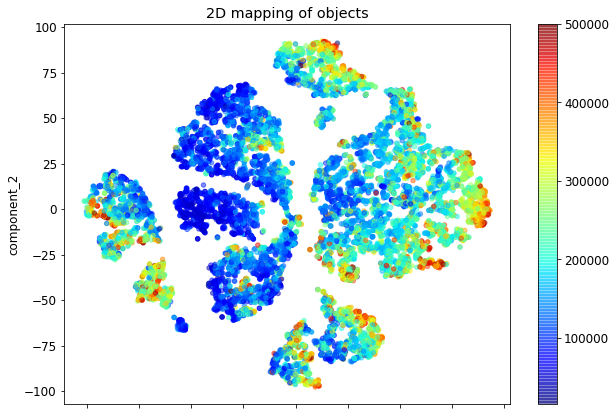

CPU times: user 3min 15s, sys: 577 ms, total: 3min 16s
Wall time: 1min 46s


In [40]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=30)
display_components_in_2D_space(components_2d_tsne, y_train)

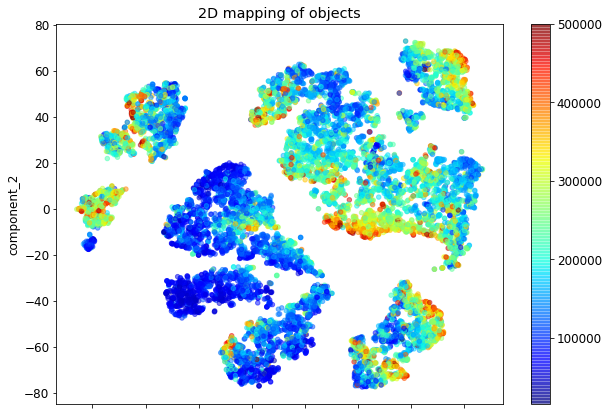

CPU times: user 3min 45s, sys: 634 ms, total: 3min 46s
Wall time: 2min 2s


In [41]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=50)
display_components_in_2D_space(components_2d_tsne, y_train)

In [ ]:
%%time
dim_reducer3d_tsne, components_3d_tsne = reduce_dims(X_train_scaled, dims=3, method='tsne')
components_3d_tsne.head(2)

CPU times: user 29min 47s, sys: 9.85 s, total: 29min 57s
Wall time: 10min 27s


component_1  component_2  component_3
0   -12.558880    -7.392291    -5.668721
1    -2.413324    -5.100667    -9.352448

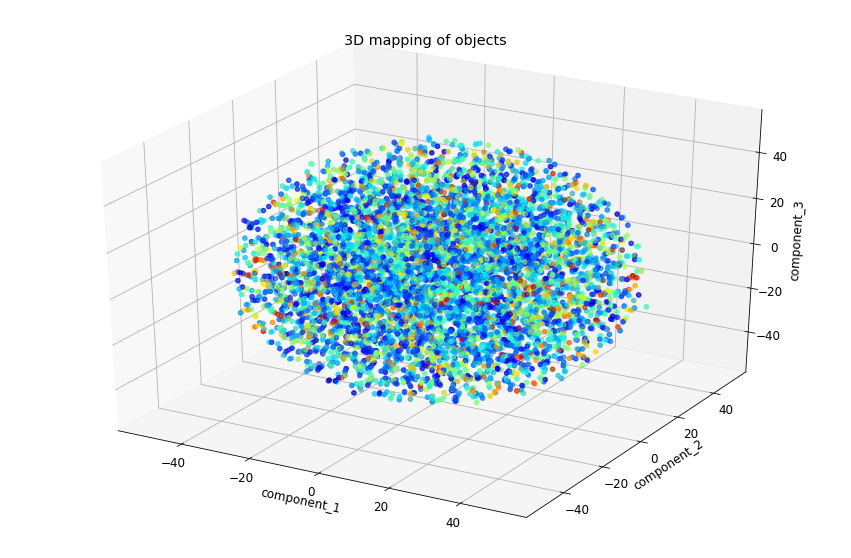

In [ ]:
display_components_in_3D_space(components_3d_tsne, y_train)

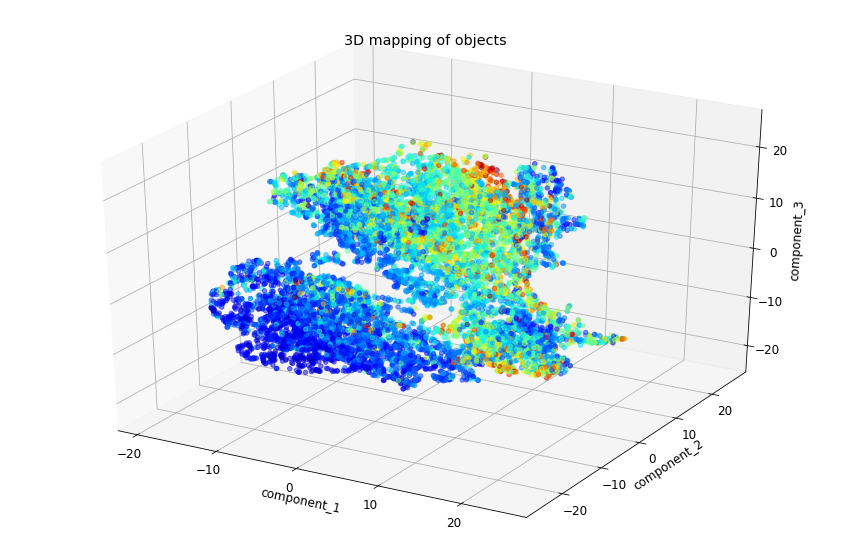

In [ ]:
display_components_in_3D_space(components_3d_tsne, y_train)

# Кластеризация <a class='anchor' id='cluster'>

Алгоритмы:
- K-means
- [Иерархическая кластеризация](https://towardsdatascience.com/https-towardsdatascience-com-hierarchical-clustering-6f3c98c9d0ca)
- [DBScan](https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a)

### Кластеризация: k-means <a class='anchor' id='kmeans'>

**Как работает k-means**

Вы указываете кол-во кластеров

1. Центры кластеров случайно инициализируются
2. От каждой точки рассчитывается расстояние до центра каждого кластера
3. Присваиваем каждую точку к тому кластеру, к центру которого она ближе
4. Пересчитываем центры кластеров: берем среднее по всем фичам --> новый центр кластера
    
итеративно повторяем шаги 2-4. Пока центры кластеров не перестанут "двигаться"

Хорошо работает, когда кластеры "шарообразные"

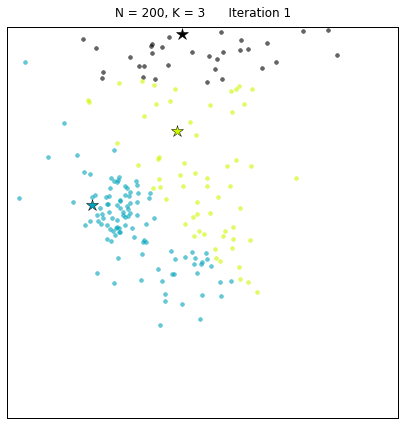

**Выделение 3 кластеров**

In [43]:
X_test_scaled.head(2)

longitude  latitude  housing_median_age  ...    INLAND  NEAR BAY  NEAR OCEAN
0   1.305473 -1.334221           -0.360234  ... -0.706745 -0.348829   -0.374977
1   1.215785 -1.273856           -1.172128  ... -0.706745 -0.348829   -0.374977

[2 rows x 12 columns]

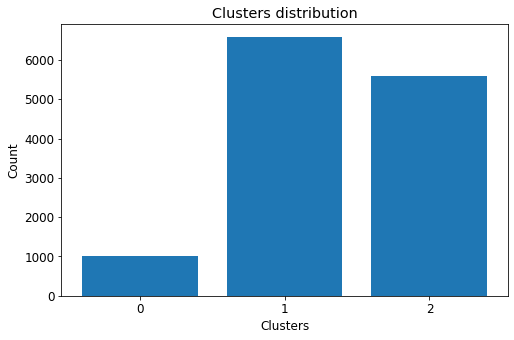

In [44]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(X_train_scaled)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')
labels_clast_3_test = kmeans_3.predict(X_test_scaled)
labels_clast_3_test = pd.Series(labels_clast_3_test, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

In [47]:
labels_clast_3[:5]

0    1
1    1
2    1
3    2
4    1
Name: clusters_3, dtype: int32

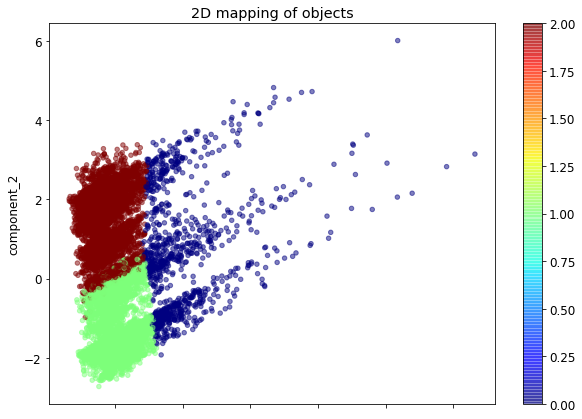

In [48]:
display_components_in_2D_space(components_2d, labels_clast_3)

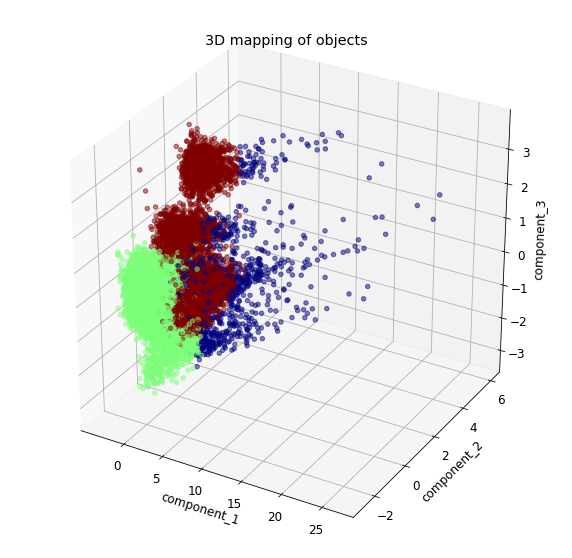

In [50]:
display_components_in_3D_space(components_3d, labels_clast_3)

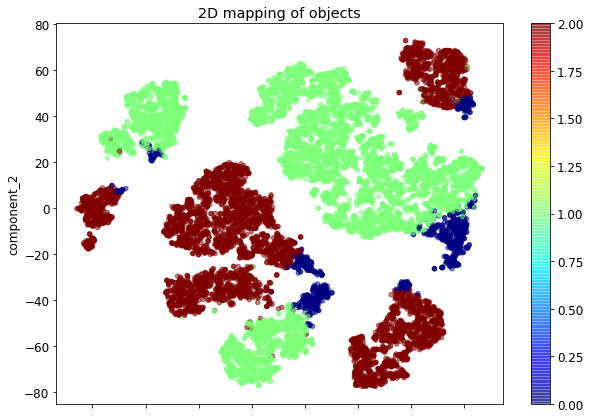

In [51]:
display_components_in_2D_space(components_2d_tsne, labels_clast_3)

In [ ]:
len(kmeans_3.cluster_centers_[0])

12

**Выделение 10 кластеров**

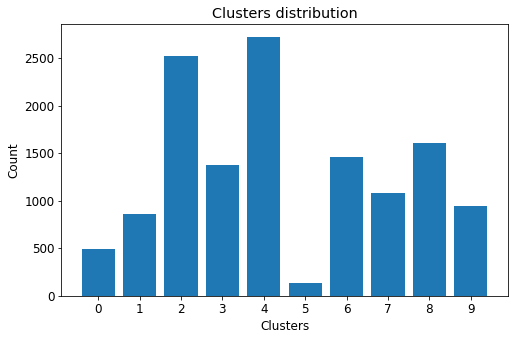

In [52]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
labels_clast_10 = kmeans_10.fit_predict(X_train_scaled)
labels_clast_10 = pd.Series(labels_clast_10, name='clusters_10')
labels_clast_10_test = kmeans_10.predict(X_test_scaled)
labels_clast_10_test = pd.Series(labels_clast_10_test, name='clusters_10')

unique, counts = np.unique(labels_clast_10, return_counts=True)
display_clusters_distribution(unique, counts)

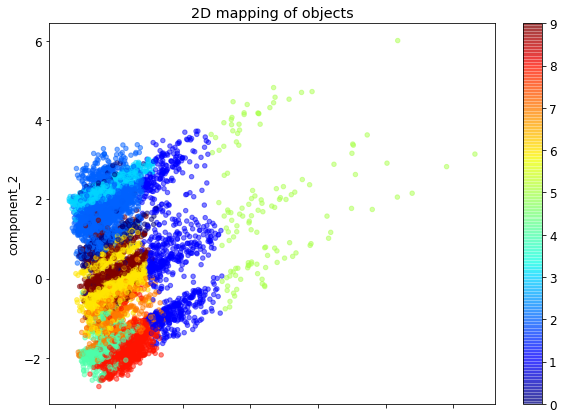

In [53]:
display_components_in_2D_space(components_2d, labels_clast_10)

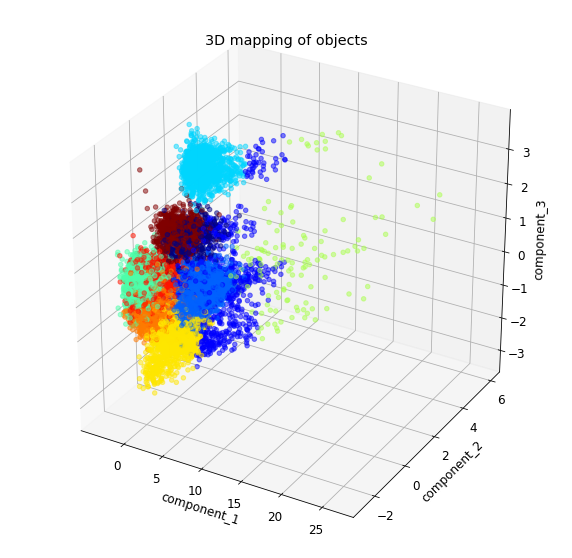

In [54]:
display_components_in_3D_space(components_3d, labels_clast_10)

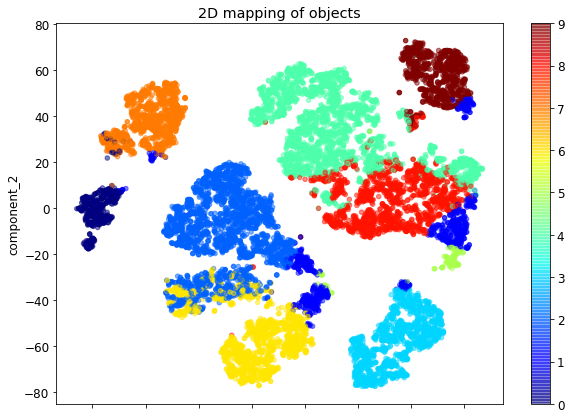

In [55]:
display_components_in_2D_space(components_2d_tsne, labels_clast_10)

### Оценка оптимального кол-ва кластеров

Дисперсия точек вокруг цетров кластеров

In [57]:
print(inspect.getsource(apply_elbow_method))

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()



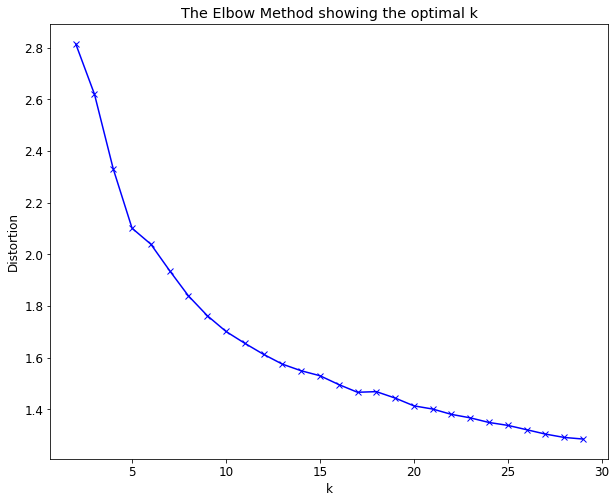

In [58]:
apply_elbow_method(X_train_scaled)

### Добавление новых признаков

In [61]:
np.unique(labels_clast_3, return_counts=True)

(array([0, 1, 2], dtype=int32), array([1006, 6583, 5593]))

In [59]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')
clusters_10_dummies = pd.get_dummies(labels_clast_10, drop_first=True, prefix='clusters_10')

X_train_cluster = pd.concat([X_train_scaled, components_3d, clusters_3_dummies, clusters_10_dummies], 
                   axis=1)
X_train_cluster.head()

longitude  latitude  ...  clusters_10_8  clusters_10_9
0   0.891912 -0.215156  ...              0              0
1   0.951704 -0.767723  ...              0              0
2   0.727484 -0.753793  ...              1              0
3  -1.569523  1.284669  ...              0              1
4   1.355300 -1.301717  ...              1              0

[5 rows x 26 columns]

In [62]:
clusters_3_dummies_test = pd.get_dummies(labels_clast_3_test, drop_first=True, prefix='clusters_3')
clusters_10_dummies_test = pd.get_dummies(labels_clast_10_test, drop_first=True, prefix='clusters_10')

X_test_cluster = pd.concat([X_test_scaled, components_3d_test, clusters_3_dummies_test, clusters_10_dummies_test], 
                   axis=1)
X_test_cluster.head()

longitude  latitude  ...  clusters_10_8  clusters_10_9
0   1.305473 -1.334221  ...              0              0
1   1.215785 -1.273856  ...              1              0
2   1.141045 -0.712002  ...              0              0
3  -2.207304  2.459455  ...              0              1
4  -0.896864  1.368251  ...              0              0

[5 rows x 26 columns]

### Переобучение и оценка финальной модели

In [63]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=30,
                                        random_state=42,  
                                        n_estimators=100)
final_model.fit(X_train_cluster, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=30,
                          random_state=42)

R2:	0.872
MAE:	23862.951
MSE:	1204761931.627


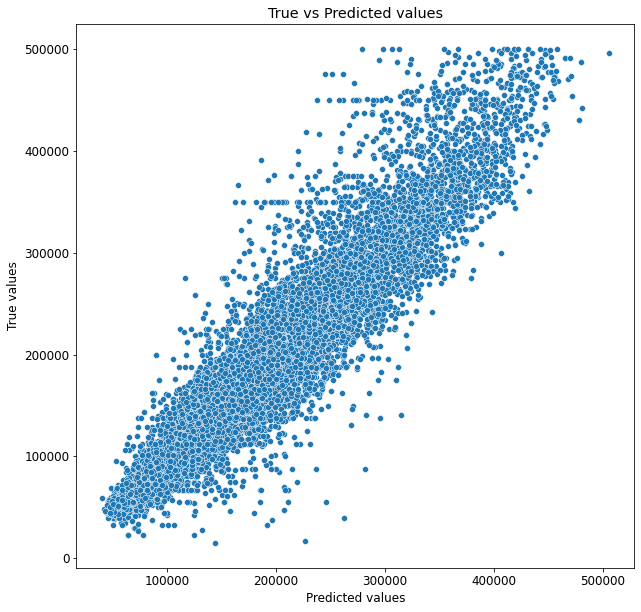

In [64]:
y_train_preds = final_model.predict(X_train_cluster)
evaluate_preds(y_train, y_train_preds)

R2:	0.802
MAE:	30071.768
MSE:	1937059631.483


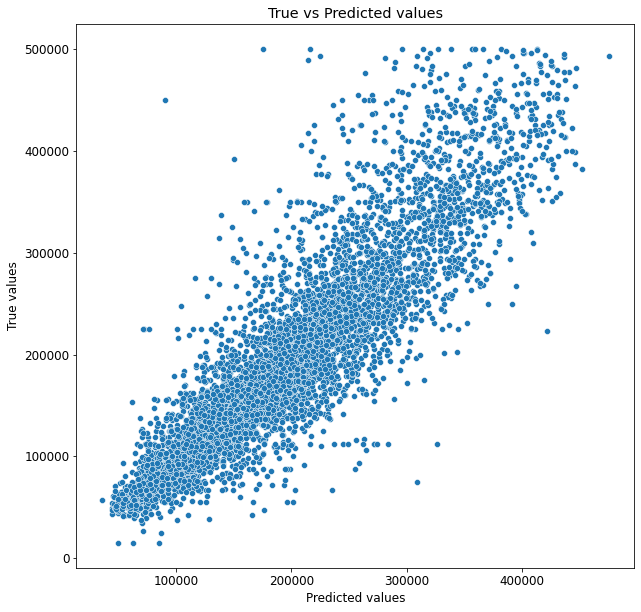

In [65]:
y_test_preds = final_model.predict(X_test_cluster)
evaluate_preds(y_test, y_test_preds)

*Без фичей с кластерами было MSE=1942212346.312 - см вебинар 4*

### Кластеризация: DBSCAN <a class='anchor' id='dbscan'>

Кол-во кластеров не указывается.

**Ключевые моменты:**
1. $\epsilon$ - радиус окружности
2. *min_samples* - количество точек, которые попали в границы окружности
3. *сore points* - ключевые точки (в их окружность попало не менее *min_samples* точек)
4. *border points* - граничные точки (в их окружность попало менее *min_samples* точек, но есть хотя бы одна *core point*)
5. *noise points* - выбросы (в их окружность не попала *core point*)


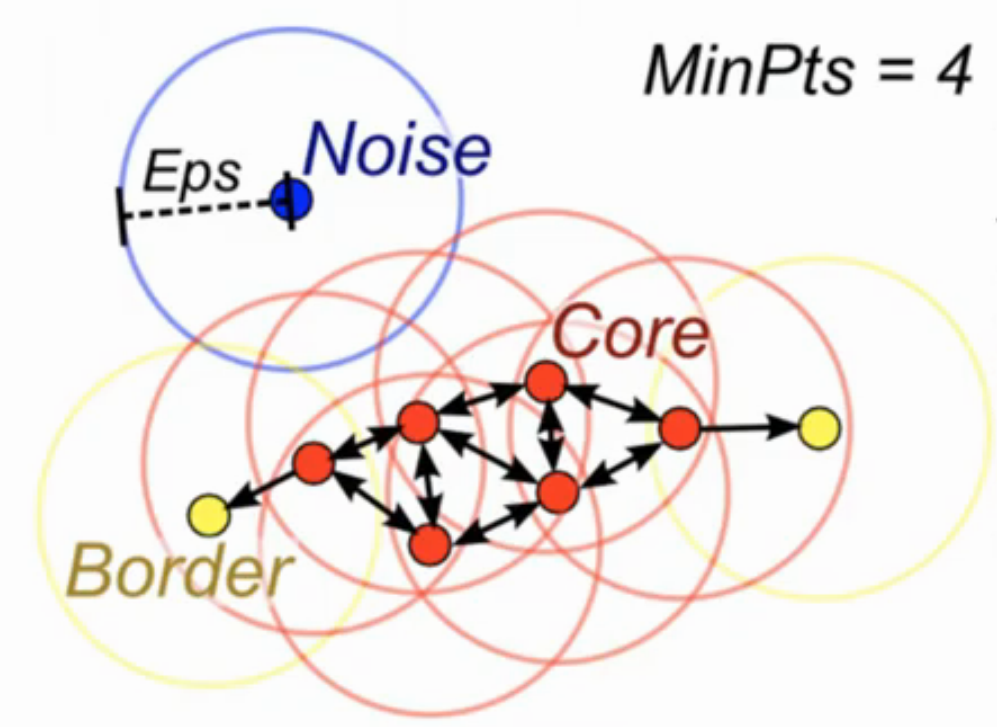

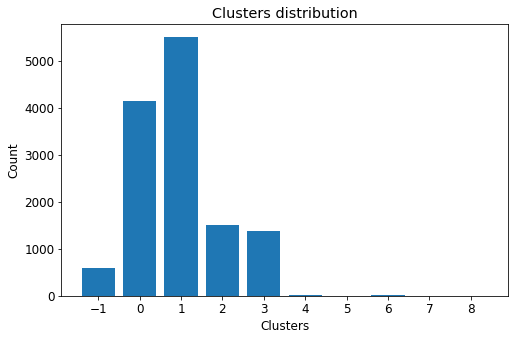

In [77]:
dbscan = DBSCAN(eps=1, min_samples=5)
labels_clast = dbscan.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_dbscan')

#labels_clast_test = dbscan.fit_predict(X_test_scaled)
#labels_clast_test = pd.Series(labels_clast_test, name='clusters_dbscan')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

## KNeighborsClassifier

In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, labels_clast)

labels_clast_test = knn.predict(X_test_scaled)

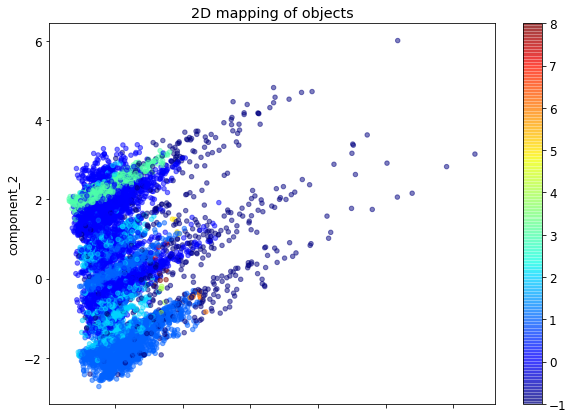

In [79]:
display_components_in_2D_space(components_2d, labels_clast)

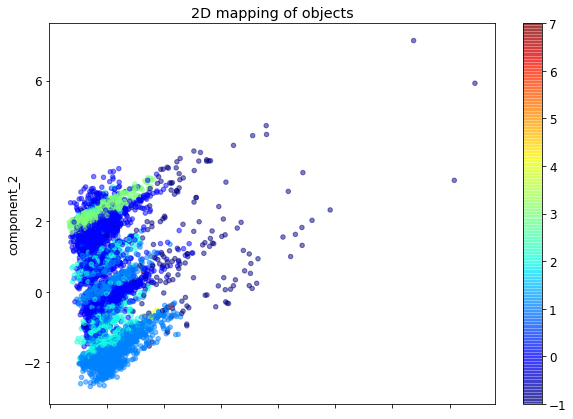

In [80]:
display_components_in_2D_space(components_2d_test, labels_clast_test)

Нанесение меток кластеров DBSCAN и K-блиэайших соседей на плоскости полученные в TSNE

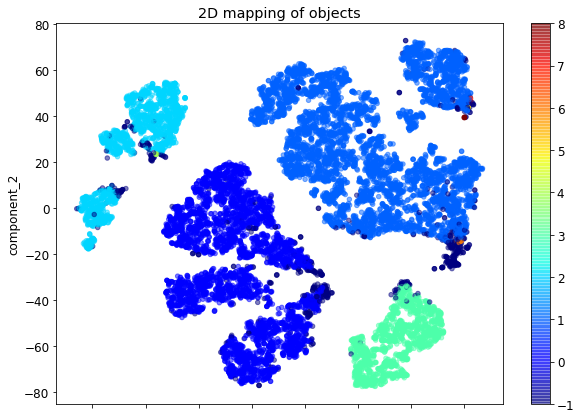

In [81]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

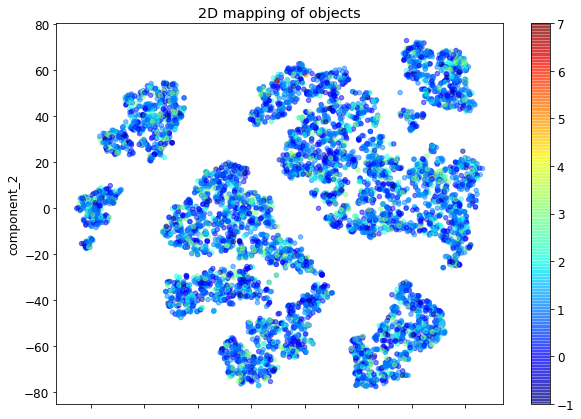

In [82]:
display_components_in_2D_space(components_2d_tsne, labels_clast_test)

### Кластеризация: Иерархическая <a class='anchor' id='aggl'>
**Агломеративная**

Кол-во кластеров указывается.

**Алгоритм**:
1. Считаем, что каждая точка - кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Пару ближайших кластеров склеиваем в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер


**Методы объединения точек:**
* Single linkage — минимум попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=min||x_i−x_j||$

* Complete linkage — максимум попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=max||x_i−x_j||$

* Average linkage — среднее попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=\frac{1}{n_in_j}∑_{x_i∈C_i}∑_{x_j∈C_j}||xi−xj||$
* Centroid linkage — расстояние между центроидами двух кластеров
$d(C_i,C_j)=||μ_i−μ_j||$

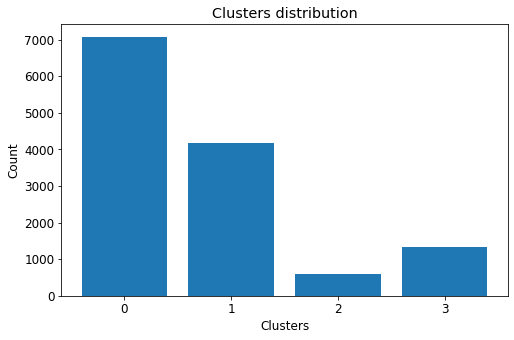

CPU times: user 8.24 s, sys: 45.4 ms, total: 8.29 s
Wall time: 8.26 s


In [84]:
%%time
aggl = AgglomerativeClustering(n_clusters=4)
labels_clast = aggl.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_aggl')

#labels_clast_test = aggl.predict(X_test_scaled)
#labels_clast_test = pd.Series(labels_clast_test, name='clusters_aggl')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [89]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_scaled, labels_clast)

labels_clast_test = knn.predict(X_test_scaled)

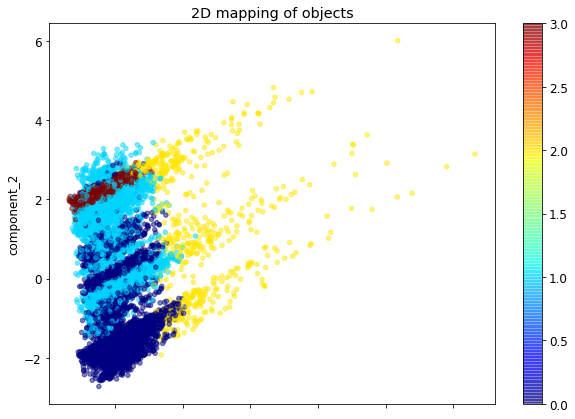

In [86]:
display_components_in_2D_space(components_2d, labels_clast)

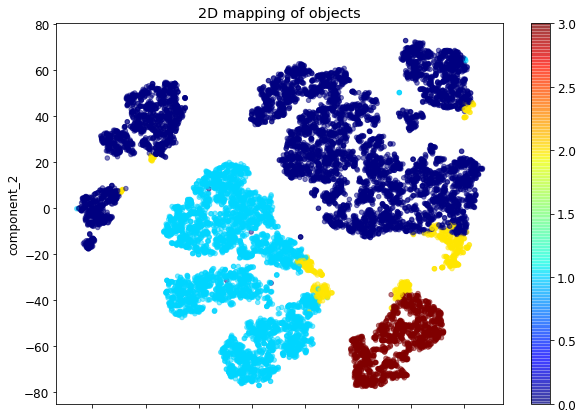

In [87]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

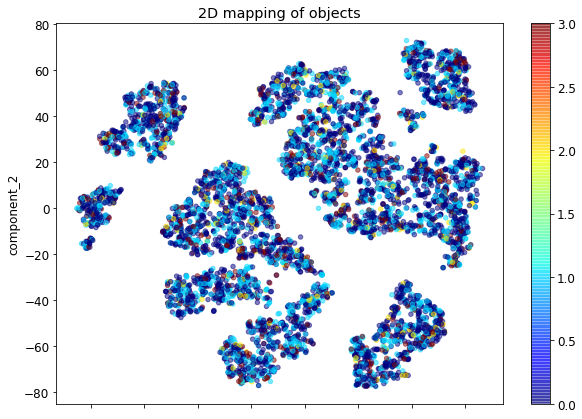

In [90]:
display_components_in_2D_space(components_2d_tsne, labels_clast_test)

[Plot Hierarchical Clustering Dendrogram¶
](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [91]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

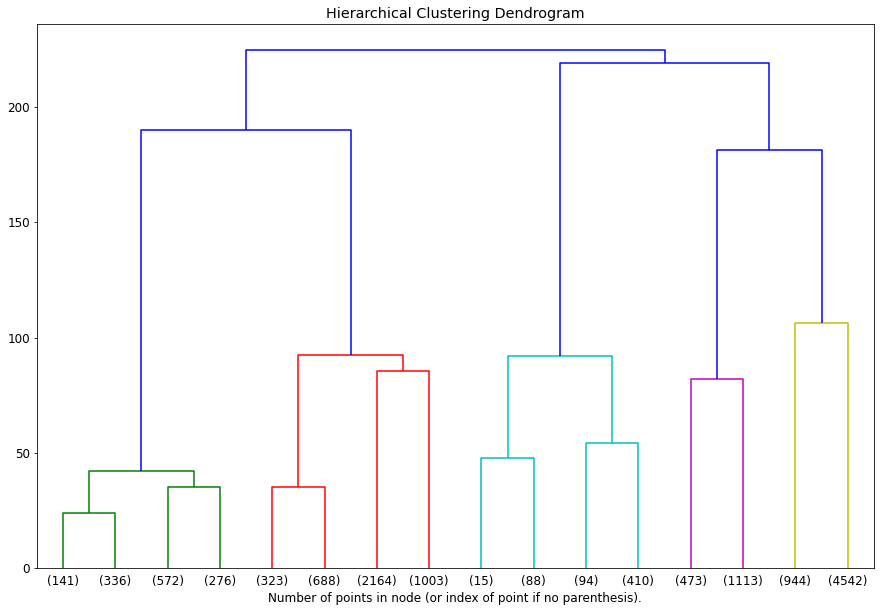

In [92]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_train_scaled)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Более наглядный пример <a class='anchor' id='example'>

Визуализация набора данных MNIST из [статьи](https://habr.com/ru/company/ods/blog/325654/)

In [93]:
from sklearn import datasets


digits = datasets.load_digits()
X = digits.data
y = digits.target

In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [95]:
y[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [96]:
X.shape

(1797, 64)

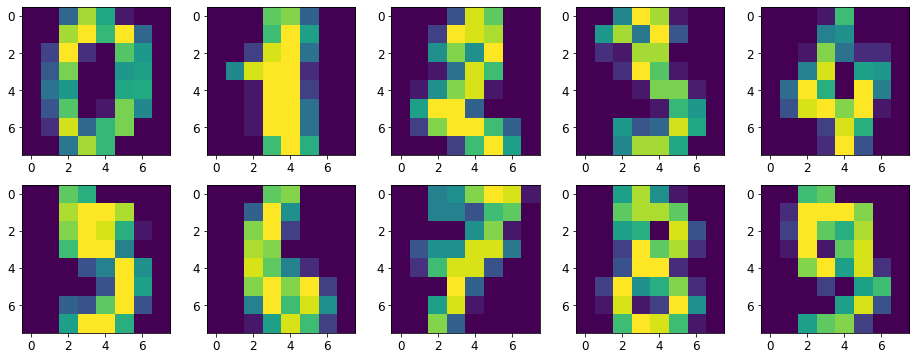

In [97]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]))

**PCA**

In [98]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

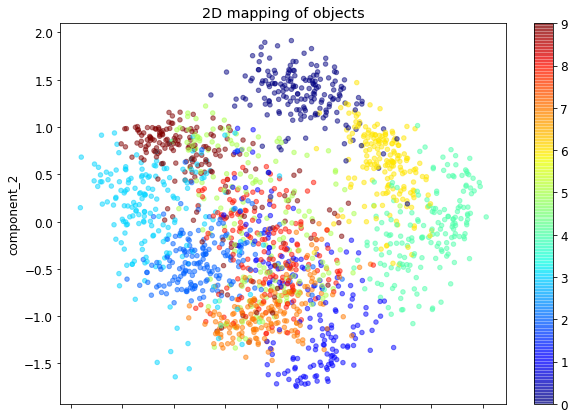

In [99]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_reduced = pd.DataFrame(data=X_reduced, columns=colnames)
components_X_reduced.head()

display_components_in_2D_space(components_X_reduced, labels=y)

**TSNE**

In [100]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, perplexity=25)

X_tsne = tsne.fit_transform(X)

CPU times: user 22.5 s, sys: 215 ms, total: 22.7 s
Wall time: 13.2 s


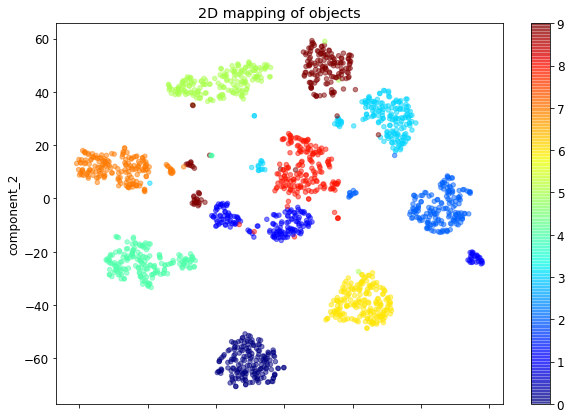

In [101]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_tsne = pd.DataFrame(data=X_tsne, columns=colnames)
components_X_tsne.head()

display_components_in_2D_space(components_X_tsne, labels=y)

**KMeans**

In [102]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels_clast = kmeans.fit_predict(X)
labels_clast = pd.Series(labels_clast, name='clusters')

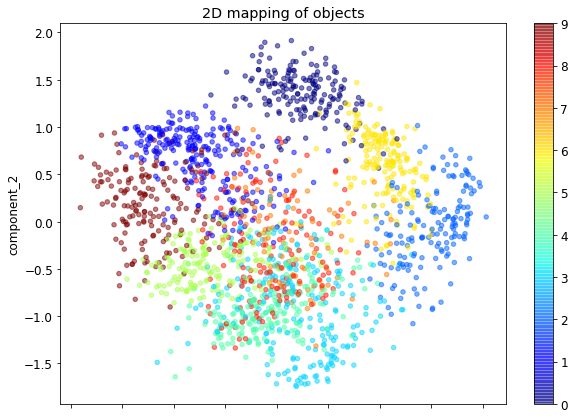

In [103]:
display_components_in_2D_space(components_X_reduced, labels=labels_clast)

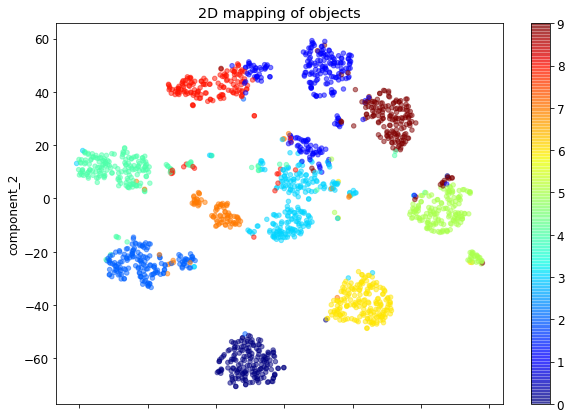

In [104]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

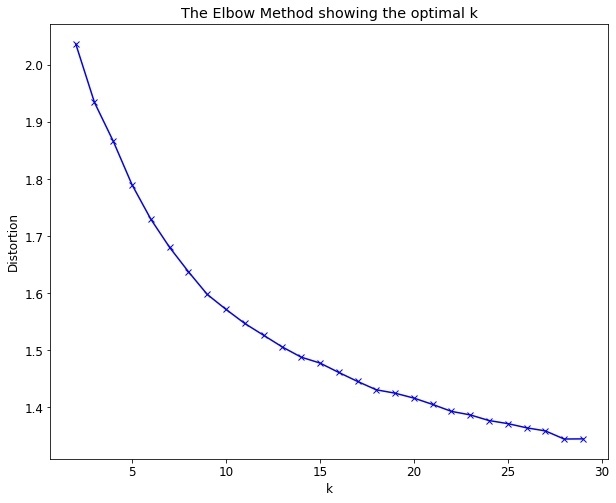

In [105]:
apply_elbow_method(X)

**DBSCAN**

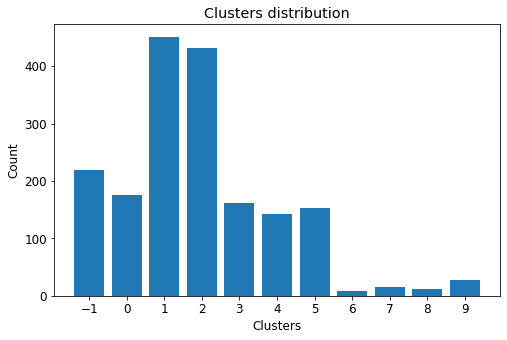

In [109]:
dbscan = DBSCAN(eps=1.4, min_samples=5)
labels_clast = dbscan.fit_predict(X)
labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

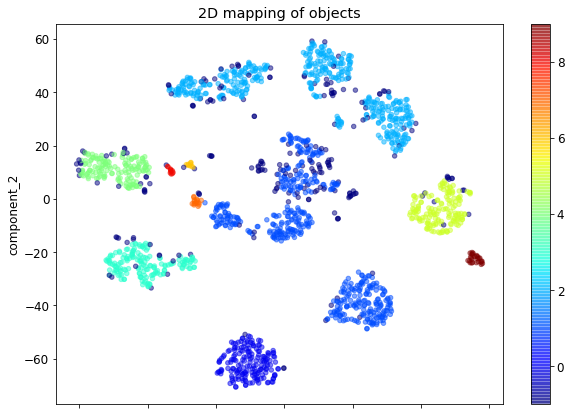

In [110]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

**AgglomerativeClustering**

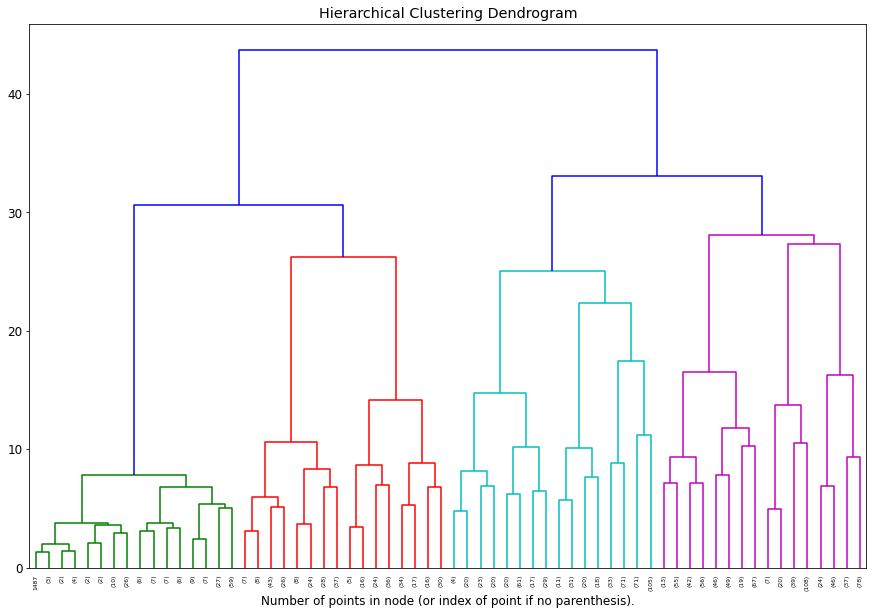

In [111]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram

plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

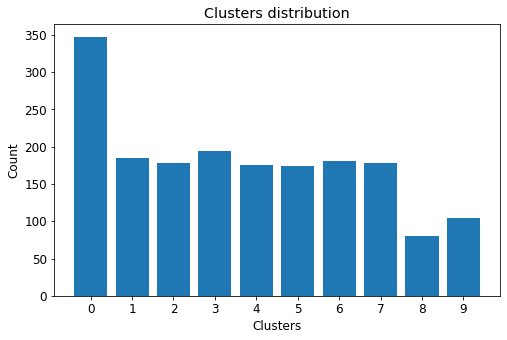

CPU times: user 290 ms, sys: 16 ms, total: 306 ms
Wall time: 314 ms


In [112]:
%%time
aggl = AgglomerativeClustering(n_clusters=10)
labels_clast = aggl.fit_predict(X)
labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

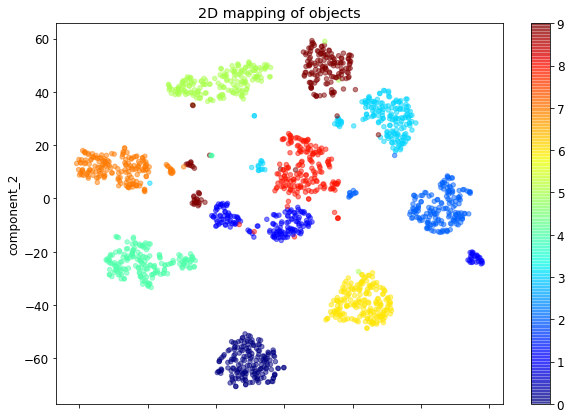

In [114]:
display_components_in_2D_space(components_X_tsne, labels=y)

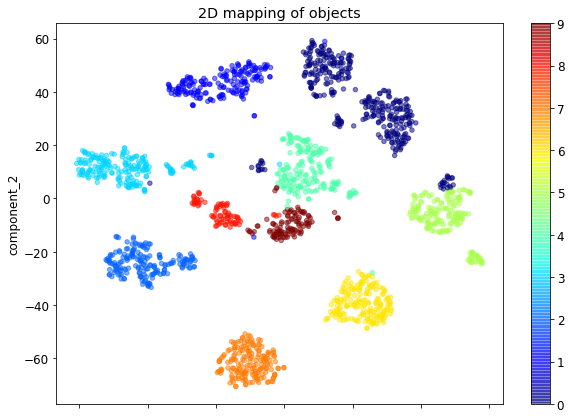

In [113]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)